<a href="https://colab.research.google.com/github/lmassaron/fine-tuning-workshop/blob/main/06_fine_tuning_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Check the GPU information
!nvidia-smi

Thu Sep 25 07:00:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P0             28W /   72W |    7615MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
# Install necessary libraries for model training and evaluation
%%capture
!pip install -U transformers trl peft accelerate bitsandbytes torch protobuf
!pip install tenacity

In [23]:
# Import and print the versions of the installed libraries
import torch
import trl
import peft
import bitsandbytes

print(f"Using PyTorch version: {torch.__version__}")
print(f"Using TRL version: {trl.__version__}")
print(f"Using peft version: {peft.__version__}")
print(f"Using bitsandbytes version: {bitsandbytes.__version__}")

Using PyTorch version: 2.8.0+cu126
Using TRL version: 0.23.0
Using peft version: 0.17.1
Using bitsandbytes version: 0.47.0


In [24]:
# Import various libraries needed for data handling, model loading, and training
import os
import gc
import warnings
import torch
import numpy as np
import pandas as pd
import torch
import subprocess
import sys
import random
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from huggingface_hub import login
from peft import LoraConfig
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import Gemma3ForCausalLM,Gemma3ForConditionalGeneration
from transformers import set_seed, BitsAndBytesConfig
from trl import GRPOConfig, GRPOTrainer, SFTConfig, SFTTrainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [25]:
DEMO = False

In [26]:
# Define configuration parameters for the model and data
class Config:
    """Configuration parameters"""

    SIZE = "3-4b"
    MODEL_NAME = f"google/gemma-{SIZE}-it"
    OUTPUT_MODEL = f"gemma-{SIZE}-finsentiment"

    max_seq_length = 512
    seed = 0

In [27]:
# Initialization script to set up the environment and Hugging Face login
def init():
    """Initialization script"""
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

    # It is recommended to set the HF_TOKEN as an environment variable
    token = os.environ.get("HF_TOKEN")
    if token:
        login(token=token)
    else:
      try:
        from google.colab import userdata
        # Retrieve your Hugging Face token from Colab's secrets manager
        # The name 'HF_TOKEN' should match the name you used in the secrets tab
        hf_token = userdata.get('HF_TOKEN')

        # Check if the token was successfully retrieved
        if hf_token:
            # Log in to Hugging Face using the retrieved token
            # The `add_to_git_credential=True` argument is optional and useful if you plan to push models to the Hub
            login(token=hf_token, add_to_git_credential=True)
            print("Hugging Face login successful using Google Colab secrets!")
        else:
            print("Error: HF_TOKEN not found in Google Colab secrets or is empty.")
            print("Please ensure you have created a secret named 'HF_TOKEN' in the 'Secrets' tab (🔑) on the left sidebar.")
      except:
        print("HF_TOKEN not set. You might need to log in manually.")

    torch.cuda.empty_cache()
    gc.collect()
    warnings.filterwarnings("ignore")

def is_bfloat16_supported():
    """Checks if the current device supports bfloat16."""
    return torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8


def info_device():
    """Get device for PyTorch"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

def cleanup(objects=None):
    """Cleans the memory"""
    if objects is not None:
        for obj in objects:
            del obj
    torch.cuda.empty_cache()
    gc.collect()

def set_deterministic(seed):
  """Sets all seeds and CUDA settings for deterministic results."""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU. [2, 3]
  set_seed(seed)

In [28]:
def install_flash_attn_conditionally():
    """
    Checks the GPU's compute capability and installs the appropriate version of flash-attn.
    """
    if not torch.cuda.is_available():
        print("No CUDA-enabled GPU found. Skipping flash-attn installation.")
        return

    try:
        # Get the compute capability of the first available GPU
        major, minor = torch.cuda.get_device_capability(0)
        compute_capability = float(f"{major}.{minor}")
        gpu_name = torch.cuda.get_device_name(0)
        print(f"Found GPU: {gpu_name} with Compute Capability: {compute_capability}")

        # Check for Ampere, Ada, Hopper, or newer architectures (for FlashAttention 2)
        if compute_capability >= 8.0:
            # Ampere, Ada, and Hopper architectures support bfloat16 and are ideal for FlashAttention 2
            is_bf16_supported = torch.cuda.is_bf16_supported()
            if is_bf16_supported:
                print("GPU supports BF16 and is compatible with FlashAttention 2.")
                print("Proceeding with installation of the latest 'flash-attn'...")
                # Install the latest version of flash-attn
                install_package("flash-attn", "-q", "--no-build-isolation") # Pass arguments correctly
                return True
            else:
                 print("GPU architecture is compatible, but BF16 is not supported. Skipping installation.")
                 return False
        # Check for Turing architecture (for original FlashAttention)
        elif compute_capability == 7.5:
            print("Turing architecture GPU detected. Compatible with original FlashAttention (v1.x).")
            #print("Proceeding with installation of 'flash-attn==1.0.9'...")
            # Install a specific version of flash-attn compatible with Turing
            #install_package("flash-attn==1.0.9", "-q", "--no-build-isolation") # Pass arguments correctly
            #return True
            print("Skipping installation because computationally demanding.")
            return False

        else:
            print(f"GPU with compute capability {compute_capability} is not supported by flash-attn. Skipping installation.")
            return False
    except Exception as e:
        print(f"An error occurred during GPU check or installation: {e}")
        return False

def install_package(package_name, *pip_args):
    """
    A helper function to install a pip package using subprocess.
    """
    try:
        command = [sys.executable, "-m", "pip", "install", package_name]
        command.extend(pip_args) # Extend with individual arguments
        subprocess.check_call(command)
        print(f"Successfully installed {package_name}.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {package_name}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [29]:
# Initialize the environment, get parameters, device, and data type
init()
params = Config()
device = info_device()
dtype = torch.bfloat16 if is_bfloat16_supported() else torch.float16
print(f"Using dtype: {dtype}")
is_flash_attn_available = install_flash_attn_conditionally()
set_deterministic(params.seed)

Hugging Face login successful using Google Colab secrets!
Using device: cuda
Using dtype: torch.bfloat16
Found GPU: NVIDIA L4 with Compute Capability: 8.9
GPU supports BF16 and is compatible with FlashAttention 2.
Proceeding with installation of the latest 'flash-attn'...


In [30]:
from tenacity import retry, stop_after_attempt, wait_fixed

# Function to load dataset from Hugging Face Hub with retries
@retry(stop=stop_after_attempt(5), wait=wait_fixed(10)) # Retry up to 5 times with 10 seconds delay
def get_data(repo_id, mapping_func=None, split="train"):
    """Upload HF dataset with retries"""
    print(f"Attempting to load dataset {repo_id}, split {split}...")
    data = load_dataset(repo_id, cache_dir="/tmp")[split]
    if mapping_func:
      data = data.map(mapping_func)
    print("Dataset loaded successfully!")
    return data

In [31]:
SYSTEM_PROMPT = "What sentiment has the following piece of financial news: "
chat_mapping = lambda x: {
            "prompt": [
                {"role": "user", "content": SYSTEM_PROMPT + "\n" + x["sentence"]},
            ], "completion": [{"role": "assistant", "content":  x["sentiment"]}]
        }

repo_id = "lmassaron/FinancialPhraseBank"
train_data = get_data(repo_id, mapping_func=chat_mapping, split="train").remove_columns(["sentiment", "sentence", "label"])
eval_data = get_data(repo_id, mapping_func=chat_mapping, split="validation").remove_columns(["sentiment", "sentence", "label"])
test_data = get_data(repo_id, mapping_func=chat_mapping, split="test").remove_columns(["sentiment", "sentence", "label"])

Attempting to load dataset lmassaron/FinancialPhraseBank, split train...
Dataset loaded successfully!
Attempting to load dataset lmassaron/FinancialPhraseBank, split validation...
Dataset loaded successfully!
Attempting to load dataset lmassaron/FinancialPhraseBank, split test...
Dataset loaded successfully!


Loading tokenizer: google/gemma-3-4b-it

--- Processing 'train' split ---


Tokenizing samples: 100%|██████████| 3872/3872 [00:01<00:00, 3463.41it/s]



--- Processing 'validation' split ---


Tokenizing samples: 100%|██████████| 484/484 [00:00<00:00, 3303.81it/s]



--- Processing 'test' split ---


Tokenizing samples: 100%|██████████| 484/484 [00:00<00:00, 3156.46it/s]



--- Maximum Token Lengths ---
Train Split: 167 tokens
Validation Split: 101 tokens
Test Split: 196 tokens
-----------------------------



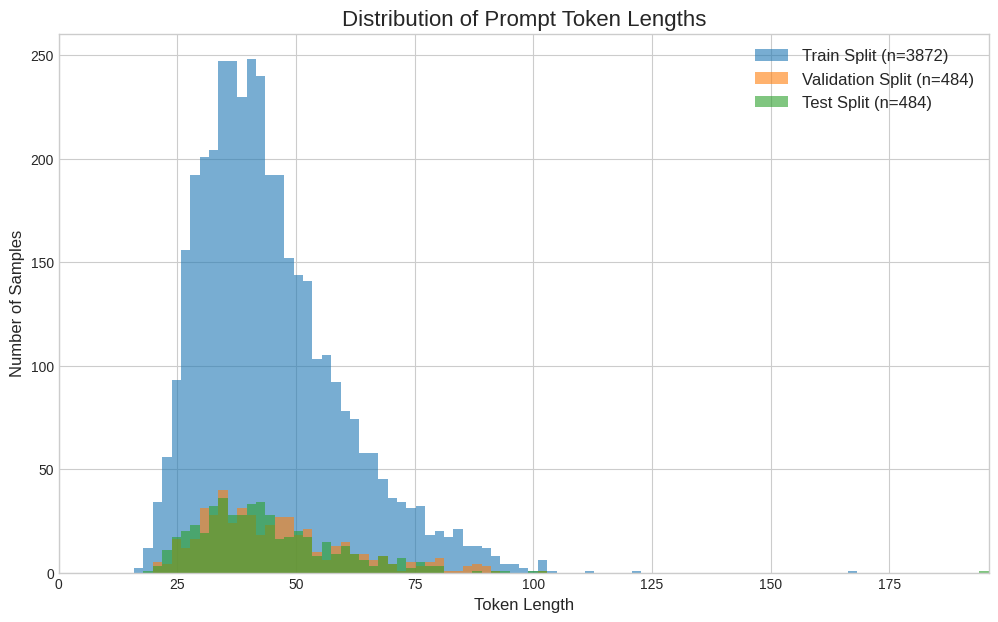

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer

# Assume 'params' and 'get_fpb_questions' are defined and available
# For example:
# from your_utils import get_fpb_questions
# class Params:
#     MODEL_NAME = "google/gemma-2b"
# params = Params()


def analyze_token_lengths(dataset, tokenizer):
    """
    Tokenizes each item in a dataset and returns a list of token lengths.

    Args:
        dataset: A Hugging Face Dataset object.
        tokenizer: An initialized Hugging Face tokenizer.

    Returns:
        A list of integers representing the token length of each prompt.
    """
    token_lengths = []
    # Using tqdm for a nice progress bar, especially for the large training set
    for item in tqdm(dataset, desc="Tokenizing samples"):
        # --- FIX: Extract the actual text from the item dictionary ---
        # Based on your previous code, the prompt is in this nested structure
        prompt_text = item["prompt"][0]["content"] + item["completion"][0]["content"]

        # Tokenize the text and get the number of tokens
        # We use .input_ids as it's the most direct way to get the token list
        num_tokens = len(tokenizer(prompt_text).input_ids)
        token_lengths.append(num_tokens)

    return token_lengths


# --- 1. Load Tokenizer ---
print(f"Loading tokenizer: {params.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# --- 2. Analyze all dataset splits ---
splits_to_analyze = [("train", train_data), ("validation", eval_data), ("test", test_data)]
all_token_lengths = {}

for split, dataset_split in splits_to_analyze:
    print(f"\n--- Processing '{split}' split ---")
    # Analyze and store the token lengths
    all_token_lengths[split] = analyze_token_lengths(dataset_split, tokenizer)

# --- 3. Print Max Token Lengths ---
print("\n--- Maximum Token Lengths ---")
for split, lengths in all_token_lengths.items():
    max_len = np.max(lengths)
    print(f"{split.title()} Split: {max_len} tokens")
print("-----------------------------\n")

# --- 4. Plot Histograms ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

# Define bins to make histograms comparable
max_overall_length = max(np.max(lengths) for lengths in all_token_lengths.values())
bins = np.linspace(0, max_overall_length, 100)  # 100 bins up to the max length

for split, lengths in all_token_lengths.items():
    ax.hist(
        lengths,
        bins=bins,
        alpha=0.6,  # Use alpha for transparency to see overlapping distributions
        label=f"{split.title()} Split (n={len(lengths)})",
    )

ax.set_title("Distribution of Prompt Token Lengths", fontsize=16)
ax.set_xlabel("Token Length", fontsize=12)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.legend(fontsize=12)
ax.set_xlim(0, max_overall_length)  # Set x-axis limit
plt.show()

In [33]:
attn_implementation = "flash_attention_2" if is_flash_attn_available else "eager"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
    bnb_4bit_use_double_quant=True,
)

model = Gemma3ForConditionalGeneration.from_pretrained(
    params.MODEL_NAME,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation=attn_implementation
)

tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME,
                                          max_seq_length=params.max_seq_length)

# Explicitly enable use_cache for faster inference
model.config.use_cache = True

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
print(f"Model: {model.name_or_path}")
print(f"Device: {model.device}")
print(f"DType: {model.dtype}")
print(f"Attention Implementation: {attn_implementation}")

if hasattr(model, "is_quantized") and model.is_quantized:
    # The quantization_config attribute holds the BitsAndBytesConfig object
    print("Quantization: Enabled")
    print(f"  - 4bit: {model.is_loaded_in_4bit}")
    print(f"  - Quant Type: {model.hf_quantizer.quantization_config.bnb_4bit_quant_type}")
    print(f"  - Compute DType: {model.hf_quantizer.quantization_config.bnb_4bit_compute_dtype}")
else:
    print("Quantization: Disabled")

Model: google/gemma-3-4b-it
Device: cuda:0
DType: torch.float16
Attention Implementation: flash_attention_2
Quantization: Enabled
  - 4bit: True
  - Quant Type: nf4
  - Compute DType: torch.bfloat16


In [35]:
# LoRA configuration
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    lora_dropout=0,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

# SFT (Supervised Fine-tuning) configuration
training_arguments = SFTConfig(
    output_dir="logs",
    seed=params.seed,
    num_train_epochs=2,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",
    logging_steps=10 if DEMO else 100,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=not(is_bfloat16_supported()),
    bf16=is_bfloat16_supported(),
    max_grad_norm=0.3,
    max_steps=30 if DEMO else -1,
    warmup_ratio=0.05,
    group_by_length=False,
    eval_strategy='steps',
    eval_steps = 10 if DEMO else 100,
    save_steps=100,
    eval_accumulation_steps=1,
    lr_scheduler_type="cosine",
    dataset_text_field="prompt",
    packing=False,
    max_length=params.max_seq_length,
    report_to="tensorboard",
)

# Initialize the trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,

)

In [36]:
# Train model
trainer.train()

# Save the fine-tuned LoRA adapter
trainer.model.save_pretrained("trained-model")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,26.156800,0.064694,2.004002,43125.000000,0.978142
200,0.700700,0.063476,2.326608,86442.000000,0.978142
300,0.703600,0.078338,2.207339,130721.000000,0.975068
400,0.649000,0.085251,1.971859,174531.000000,0.978825
500,0.528900,0.054184,2.078534,217602.000000,0.979850
600,0.354300,0.069903,1.922573,261234.000000,0.981557
700,0.273600,0.096848,1.894820,304683.000000,0.980191
800,0.233700,0.077985,1.877014,348542.000000,0.981557
900,0.269900,0.074410,1.869877,392318.000000,0.982582


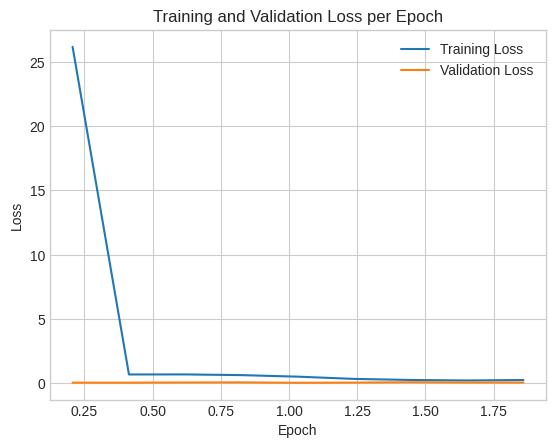

In [37]:
# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

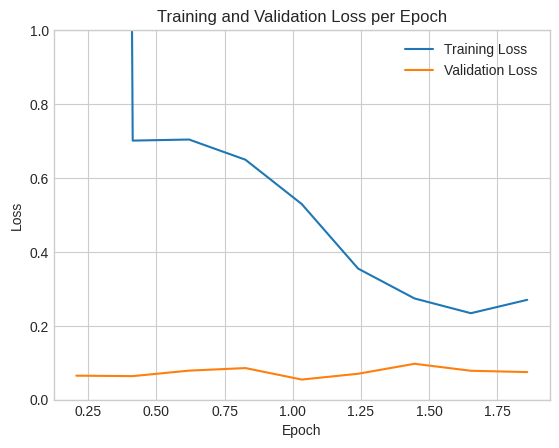

In [51]:
# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.ylim(top=1.0, bottom=0.0) # Set the lower limit of the y-axis to 1.0
plt.show()

In [38]:
trained_model = trainer.model.eval()

In [39]:
trained_model.save_pretrained("lora_sentmodel")
tokenizer.save_pretrained("lora_sentmodel")

('lora_sentmodel/tokenizer_config.json',
 'lora_sentmodel/special_tokens_map.json',
 'lora_sentmodel/chat_template.jinja',
 'lora_sentmodel/tokenizer.model',
 'lora_sentmodel/added_tokens.json',
 'lora_sentmodel/tokenizer.json')

In [40]:
merged_model = trained_model.merge_and_unload()
merged_model.save_pretrained("sentmodel")
tokenizer.save_pretrained("sentmodel")

('sentmodel/tokenizer_config.json',
 'sentmodel/special_tokens_map.json',
 'sentmodel/chat_template.jinja',
 'sentmodel/tokenizer.model',
 'sentmodel/added_tokens.json',
 'sentmodel/tokenizer.json')

In [41]:
def get_directory_size(directory_path):
    """Calculates the total size of a directory and its subdirectories in bytes."""
    total_size = 0
    # os.walk generates the file names in a directory tree
    for dirpath, dirnames, filenames in os.walk(directory_path):
        for f in filenames:
            # os.path.join creates a full file path
            fp = os.path.join(dirpath, f)
            # os.path.getsize gets the size of the file
            # os.path.islink checks to avoid errors with symbolic links
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

bytes_to_gb = 1024 * 1024 * 1024 # or 1e9 for Gigabytes vs. Gibibytes

for directory in ["./lora_sentmodel", "./sentmodel"]:
    # Get size in bytes
    size_in_bytes = get_directory_size(directory)

    # Convert to GB
    size_in_gb = size_in_bytes / bytes_to_gb

    # Print the result, formatted to 2 decimal places
    print(f"Directory '{directory}': {size_in_gb:.2f} GB")

Directory './lora_sentmodel': 0.28 GB
Directory './sentmodel': 3.06 GB


In [42]:
if not DEMO:
  repo_name = f"lmassaron/{params.OUTPUT_MODEL}_lora"

  # Push the model to the Hub
  trained_model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors: 100%|##########|  40.0B /  40.0B            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...p50y26q4u/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mp50y26q4u/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/gemma-3-4b-finsentiment_lora


In [43]:
if not DEMO:
  repo_name = f"lmassaron/{params.OUTPUT_MODEL}"

  # Push the model to the Hub
  merged_model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...otuow21/model.safetensors:   0%|          | 8.90MB / 3.25GB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pgqmoccid/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mpgqmoccid/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/gemma-3-4b-finsentiment


In [44]:
def generate_prediction(model, tokenizer, prompt):
    """Generates a prediction from the model given a prompt."""
    inputs = tokenizer.apply_chat_template(
        prompt,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt").to(device)

    # Generate the output sequence
    output_sequences = model.generate(
        input_ids=inputs,
        max_new_tokens=50, # Adjust based on expected output length
        pad_token_id=tokenizer.pad_token_id, # Can often be omitted if config is correct
        eos_token_id=tokenizer.eos_token_id
    )

    # Decode the response, making sure to decode only the newly generated tokens
    # The generated sequence includes the input, so we slice it off.
    response_ids = output_sequences[0][inputs.shape[-1]:]
    generated_text = tokenizer.decode(response_ids, skip_special_tokens=True)

    return generated_text.strip()

In [45]:
results_log = list()

for message in tqdm(test_data):
  true_answer = message['completion'][0]['content']
  generated_answer = generate_prediction(merged_model,
                                         tokenizer,
                                         message["prompt"])
  if "positive" in generated_answer.lower():
    parsed_answer = "positive"
  elif "negative" in generated_answer.lower():
    parsed_answer = "negative"
  elif "neutral" in generated_answer.lower():
    parsed_answer = "neutral"
  else:
    parsed_answer = "n/a"

  results_log.append({
      "prompt": message["prompt"],
      "ground_truth": true_answer,
      "model_output": generated_answer,
      "parsed_prediction": parsed_answer
  })

100%|██████████| 484/484 [46:35<00:00,  5.78s/it]


In [46]:
results_df = pd.DataFrame(results_log)

In [47]:
ground_truth_labels = results_df.ground_truth
predicted_labels = results_df.parsed_prediction

In [48]:
# --- Calculate the Metrics ---

# Define the possible labels in your dataset
class_labels = ["positive", "negative", "neutral"]

# 1. Overall Accuracy
# This is the percentage of correct predictions out of the total number of predictions.
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print(f"Overall Accuracy: {accuracy:.2%}\n")

# 2. Precision, Recall, and F1-Score (calculated for each class)
# 'average="weighted"' accounts for class imbalance by weighting the score of each class by its support.
precision = precision_score(ground_truth_labels, predicted_labels, average='weighted', labels=class_labels)
recall = recall_score(ground_truth_labels, predicted_labels, average='weighted', labels=class_labels)
f1 = f1_score(ground_truth_labels, predicted_labels, average='weighted', labels=class_labels)

print(f"Weighted Precision: {precision:.2%}")
print(f"Weighted Recall: {recall:.2%}")
print(f"Weighted F1-Score: {f1:.2%}\n")


# 3. Detailed Classification Report (Most useful)
# This report breaks down precision, recall, and f1-score for each individual class.
report = classification_report(ground_truth_labels, predicted_labels, labels=class_labels)

print("--- Classification Report ---")
print(report)

Overall Accuracy: 47.31%

Weighted Precision: 75.20%
Weighted Recall: 47.31%
Weighted F1-Score: 38.63%

--- Classification Report ---
              precision    recall  f1-score   support

    positive       0.37      0.98      0.54       136
    negative       0.67      0.97      0.79        61
     neutral       0.95      0.13      0.23       287

   micro avg       0.47      0.47      0.47       484
   macro avg       0.66      0.69      0.52       484
weighted avg       0.75      0.47      0.39       484

